## Notebook Overview

This notebook builds upon the prepared data from the previous notebook (`02_feature_selection_and_preparation.ipynb`) and focuses on **Exploratory Data Analysis (EDA)**. This stage involves gaining a deeper understanding of the data through visualizations, summary statistics, and various analytical techniques. The insights gained from EDA will inform subsequent feature engineering, model selection, and interpretation of results.

### 0.3.1 Objectives

The main objectives of this notebook are:

1. **Understand Data Distributions:** Visualize the distributions of individual features (numerical and categorical) to identify patterns, outliers, and potential data quality issues.
2. **Explore Feature Relationships:** Analyze the relationships between features and the target variable (loan default) to identify potential predictors and understand their influence.
3. **Identify Key Insights:** Uncover patterns, trends, and anomalies in the data that can provide valuable insights for building effective credit risk models.
4. **Inform Feature Engineering and Modeling:** Use the insights gained from EDA to guide further feature engineering efforts and inform the selection of appropriate machine learning models.

### 0.3.2 Importance of Exploratory Data Analysis

EDA plays a vital role in the success of a machine learning project for several reasons:

- **Data Understanding:** EDA helps us gain a deeper understanding of the data's structure, characteristics, and potential issues.
- **Feature Selection:** EDA can reveal which features are most relevant to the target variable and guide feature engineering efforts.
- **Model Selection:** EDA can provide insights into the types of machine learning models that might be most suitable for the data.
- **Problem Identification:** EDA can help identify potential problems with the data, such as missing values, outliers, or inconsistencies.
- **Insight Generation:** EDA can uncover hidden patterns, trends, and relationships in the data that can lead to valuable business insights.

### 0.3.3 Our Approach

In this notebook, we will employ a variety of EDA techniques, including:

- **Summary Statistics:** Calculate descriptive statistics (mean, median, standard deviation, etc.) for numerical features to understand their central tendency and spread.
- **Histograms and Box Plots:** Visualize the distributions of numerical features to identify skewness, outliers, and potential data transformations needed.
- **Bar Charts:** Explore the frequencies and proportions of categorical features to understand their representation in the dataset.
- **Scatter Plots and Correlation Matrices:** Analyze the relationships between numerical features and the target variable to identify potential predictors and understand their correlations.
- **Cross-Tabulations:** Examine the relationships between categorical features and the target variable to identify potential patterns and associations.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl
from IPython.display import Image

from retail_bank_risk.basic_visualizations_utils import (
    plot_categorical_features_by_target,
    plot_combined_boxplots,
    plot_combined_histograms,
    plot_correlation_matrix,
    plot_single_bar_chart,
)
from retail_bank_risk.data_preprocessing_utils import (
    create_stratified_sample,
)
from retail_bank_risk.statistical_analysis_utils import run_statistical_analysis

In [3]:
application_train = pl.read_parquet(
    "../data/processed/application_train_prepared.parquet"
)
application_test = pl.read_parquet(
    "../data/processed/application_test_prepared.parquet"
)

In [40]:
application_train.head()

name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,reg_city_not_work_city,organization_type,ext_source_2,days_id_publish,ext_source_3,days_last_phone_change,days_birth,sk_id_curr,amt_income_total,amt_credit,amt_annuity,amt_goods_price,target,is_anomaly
cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,cat,bool
"""Cash loans""","""M""","""N""","""Y""","""Unaccompanied""","""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""","""2""","""2""","""WEDNESDAY""","""0""","""Business Entity Type 3""",0.262949,-2120.0,0.139376,-1134.0,-9461.0,100002.0,202500.0,406597.5,24700.5,351000.0,"""1""",false
"""Cash loans""","""F""","""N""","""N""","""Family""","""State servant""","""Higher education""","""Married""","""House / apartment""","""1""","""1""","""MONDAY""","""0""","""School""",0.622246,-291.0,0.552591,-828.0,-16765.0,100003.0,270000.0,1293502.5,35698.5,1.1295e6,"""0""",false
"""Revolving loans""","""M""","""Y""","""Y""","""Unaccompanied""","""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""","""2""","""2""","""MONDAY""","""0""","""Government""",0.555912,-2531.0,0.729567,-815.0,-19046.0,100004.0,67500.0,135000.0,6750.0,135000.0,"""0""",false
"""Cash loans""","""F""","""N""","""Y""","""Unaccompanied""","""Working""","""Secondary / secondary special""","""Civil marriage""","""House / apartment""","""2""","""2""","""WEDNESDAY""","""0""","""Business Entity Type 3""",0.650442,-2437.0,0.509527,-617.0,-19005.0,100006.0,135000.0,312682.5,29686.5,297000.0,"""0""",false
"""Cash loans""","""M""","""N""","""Y""","""Unaccompanied""","""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""","""2""","""2""","""THURSDAY""","""1""","""Religion""",0.322738,-3458.0,0.441058,-1106.0,-19932.0,100007.0,121500.0,513000.0,21865.5,513000.0,"""0""",false


As we have loaded our data, let's display basic summary statistics for our dataset to get an overview of the distribution of our numerical features.


In [4]:
numerical_dtypes = [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32]
numerical_reduced_train = application_train.select(pl.col(numerical_dtypes))

numerical_reduced_train.describe()

statistic,ext_source_2,days_id_publish,ext_source_3,days_last_phone_change,days_birth,sk_id_curr,amt_income_total,amt_credit,amt_annuity,amt_goods_price
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0,307511.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.51437,-2994.202373,0.511425,-962.857217,-16036.995067,278180.518577,168797.919297,599025.999706,27108.56683,538151.990976
"""std""",0.190904,1509.450419,0.179542,826.807602,4363.988632,102790.175348,237123.146279,402490.776996,14493.61076,369409.041164
"""min""",8.1736e-8,-7197.0,0.000527,-4292.0,-25229.0,100002.0,25650.0,45000.0,1615.5,40500.0
"""25%""",0.392702,-4299.0,0.39622,-1570.0,-19682.0,189146.0,112500.0,270000.0,16524.0,238500.0
"""50%""",0.565757,-3254.0,0.528814,-757.0,-15750.0,278202.0,147150.0,513531.0,24903.0,450000.0
"""75%""",0.663451,-1720.0,0.64633,-274.0,-12413.0,367143.0,202500.0,808650.0,34596.0,679500.0
"""max""",0.855,0.0,0.89601,0.0,-7489.0,456255.0,1.17e8,4.05e6,258025.5,4.05e6


**Time-Related Features (days):**

- Generally skewed towards more recent events (phone/ID changes).

**External Source Scores:**

- Slightly left-skewed, potentially indicating a tendency towards higher scores.
  Financial Features:
- Income, loan amount, annuity, and goods price are all right-skewed.
- This indicates a small number of applicants with very high values.
- Suggests potential need for data transformations (e.g., log transformation) and outlier handling to improve model performance.

**Key Takeaways:**

- Time-related features might reveal insights into creditworthiness based on the recency of events.
- Skewed financial features require careful consideration during analysis and modeling.

**Next**, we can visualize feature distributions **using a stratified sample of 10,000 rows to ensure representation of both classes in our imbalanced target variable.**


In [5]:
pd_application_train = create_stratified_sample(
    application_train, "target", 10000
)
pd_application_test = application_test.to_pandas()

/Users/vytautasbunevicius/retail-bank-risk-evaluation/src/retail_bank_risk/data_preprocessing_utils.py:599: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_df = data.to_pandas().groupby(target_column, group_keys=False).apply(


In [6]:
target_feature = "target"

In [7]:
numerical_features_financial = [
    "ext_source_2",
    "ext_source_3",
    "amt_income_total",
    "amt_credit",
]

numerical_features_loan_specifics = ["amt_annuity", "amt_goods_price"]

numerical_features_timing_history = [
    "days_last_phone_change",
    "days_birth",
    "days_id_publish",
]

With our features grouped, we can begin visualizing their distributions, starting with an analysis of the target variable and the amount of outliers.


In [8]:
plot_single_bar_chart(
    pd_application_train,
    "target",
    save_path="../images/eda/target_distribution.png",
)

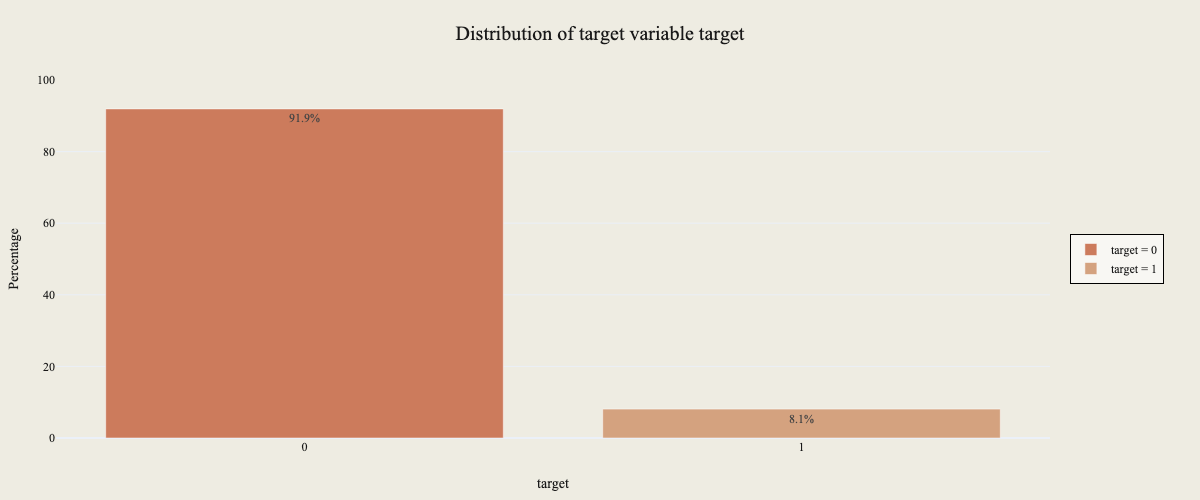

In [9]:
Image(filename="../images/eda/target_distribution.png")

Due to the significant class imbalance seen in the target variable, we will visualize the distribution of numerical features using the entire dataset, rather than comparing distributions separately for each target class.


In [10]:
plot_combined_histograms(
    pd_application_train,
    numerical_features_financial,
    save_path="../images/eda/numerical_features_financial.png",
)

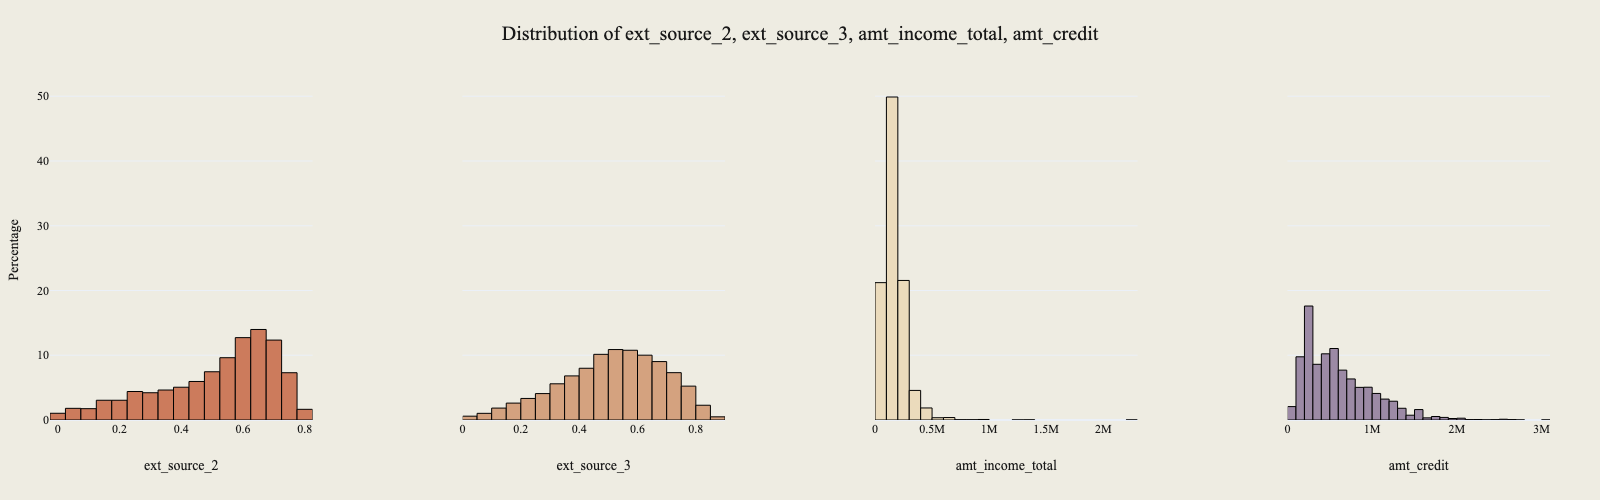

In [11]:
Image(filename="../images/eda/numerical_features_financial.png")

- **ext_source_2 & ext_source_3:** Both show a somewhat normal distribution, but with a peak towards the lower end of their values. This suggests these external sources might have a bias towards lower scores.
- **amt_income_total:** Heavily skewed to the right, indicating most incomes are clustered at the lower end with a few very high earners.
- **amt_credit:** Also right-skewed, meaning most loans are for smaller amounts, with a long tail of larger loans.


In [12]:
plot_combined_histograms(
    pd_application_train,
    numerical_features_loan_specifics,
    save_path="../images/eda/numerical_features_loan_specifics.png",
)

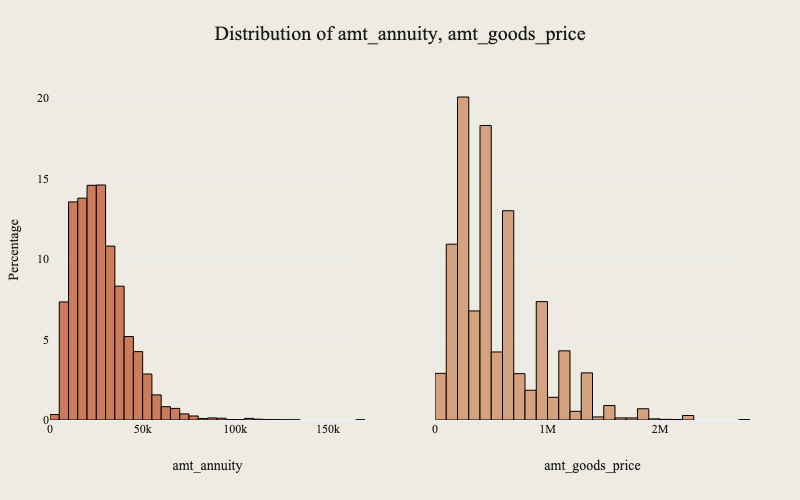

In [13]:
Image(filename="../images/eda/numerical_features_loan_specifics.png")

- **amt_annuity:** Right-skewed, suggesting most loan annuity payments are smaller, with a few much larger payments.
- **amt_goods_price:** Right-skewed as well, indicating most loans are for lower-priced goods, with a tail of loans for more expensive items.


In [14]:
plot_combined_histograms(
    pd_application_train,
    numerical_features_timing_history,
    save_path="../images/eda/numerical_features_timing_history.png",
)

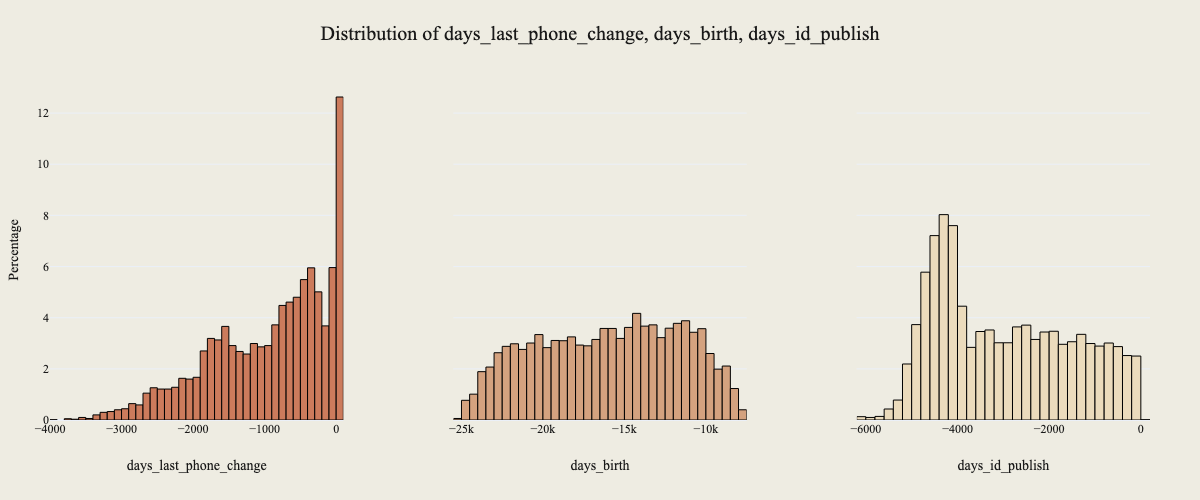

In [15]:
Image(filename="../images/eda/numerical_features_timing_history.png")

- **days_last_phone_change:** Mostly clustered towards more recent phone changes (closer to 0), with a sharp drop-off for older changes.
- **days_birth:** Shows the age distribution of loan applicants, with a peak around middle age. The negative values represent days before the loan application.
- **days_id_publish:** Right-skewed, indicating most applicants provided their ID relatively recently before the loan application.

General observations:

- **Right Skew:** Many of the financial features (income, credit, annuity, goods price) are right-skewed, which is common in financial data. This indicates a concentration of lower values with a few high-value outliers.
- **External Sources:** The distribution of `ext_source_2` and `ext_source_3` suggests potential bias in these external scoring systems.
- **Time-Based Features:** The distributions of `days_last_phone_change`, `days_birth`, and `days_id_publish` provide insights into the recency of actions and the age distribution of applicants.

**Next up**, let's examine the distributions of our categorical features.


In [16]:
categorical_features_personal = [
    "name_contract_type",
    "code_gender",
    "flag_own_car",
    "flag_own_realty",
]

categorical_features_housing_family = [
    "name_type_suite",
    "name_income_type",
    "name_education_type",
    "name_family_status",
]

categorical_features_occupation = [
    "name_housing_type",
]

categorical_features_work_context = [
    "weekday_appr_process_start",
    "reg_city_not_work_city",
]

categorical_features_ratings = [
    "region_rating_client",
    "region_rating_client_w_city",
]

In [17]:
all_categorical_features = (
    categorical_features_personal
    + categorical_features_housing_family
    + categorical_features_occupation
    + categorical_features_work_context
    + categorical_features_ratings
)

all_numerical_features = (
    numerical_features_timing_history
    + numerical_features_financial
    + numerical_features_loan_specifics
)

In [18]:
plot_categorical_features_by_target(
    pd_application_train,
    categorical_features_personal,
    target_feature,
    save_path="../images/eda/categorical_features_personal.png",
)

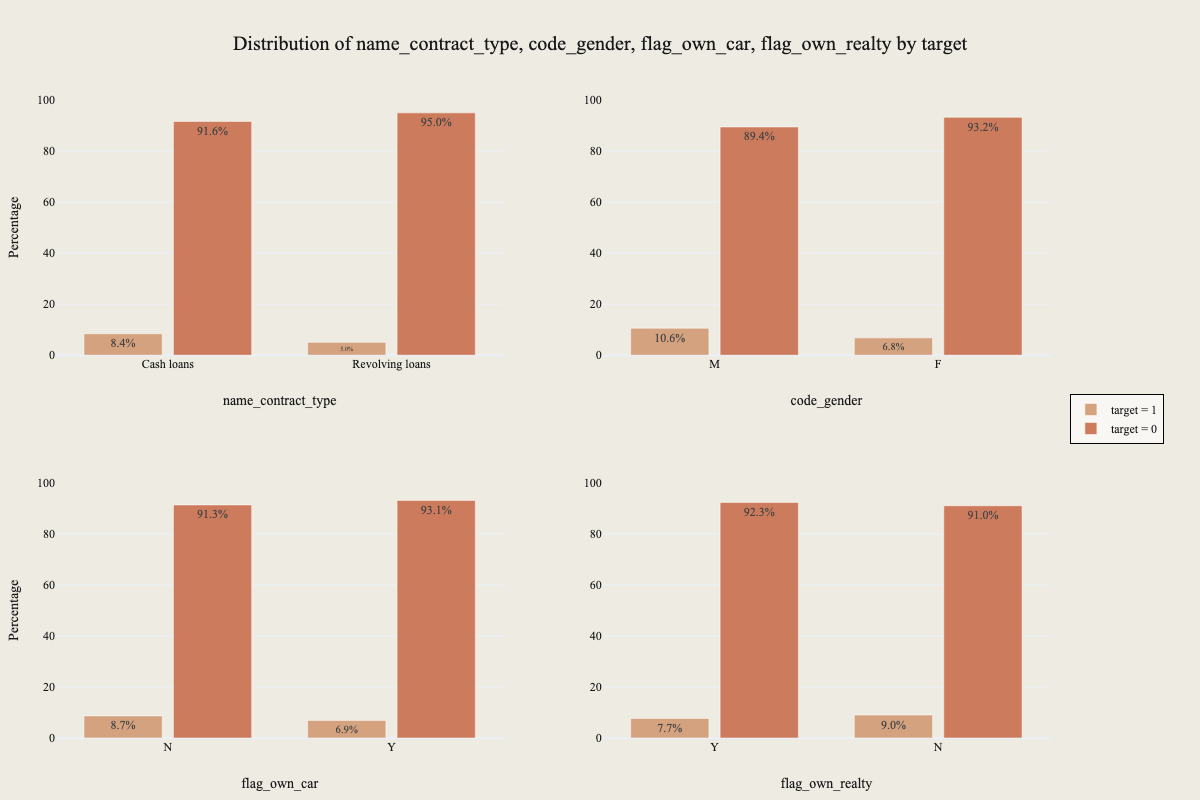

In [19]:
Image(filename="../images/eda/categorical_features_personal.png")

- **name_contract_type:** Revolving loans (like credit cards) have a much lower risk of default compared to cash loans.
- **code_gender:** Males have a slightly higher risk of loan default.
- **flag_own_car:** Not owning a car is associated with a slightly higher risk of loan default.
- **flag_own_realty:** Not owning realty is associated with a slightly higher risk of loan default.


In [20]:
plot_categorical_features_by_target(
    pd_application_train,
    categorical_features_housing_family,
    target_feature,
    save_path="../images/eda/categorical_features_housing_family.png",
)

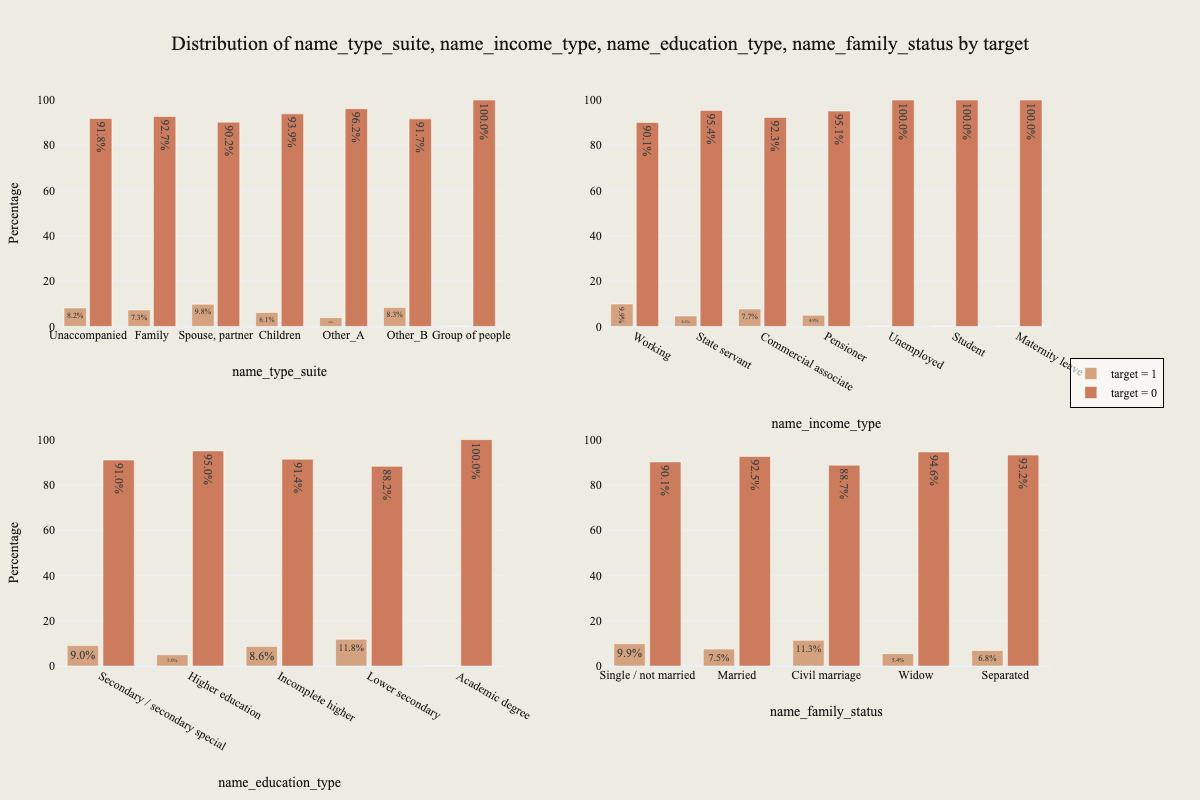

In [21]:
Image(filename="../images/eda/categorical_features_housing_family.png")

- **name_family_status:** Being married (especially in a civil marriage) is associated with a lower risk of loan default.
- **name_type_suite:** Living with family is associated with a lower risk of loan default.
- **name_education_type:** Lower levels of education show a slightly higher risk of loan default.
- **name_income_type:** Working and Commercial associate income types have the lowest risk of loan default.


In [22]:
plot_categorical_features_by_target(
    pd_application_train,
    categorical_features_occupation,
    target_feature,
    save_path="../images/eda/categorical_features_occupation.png",
)

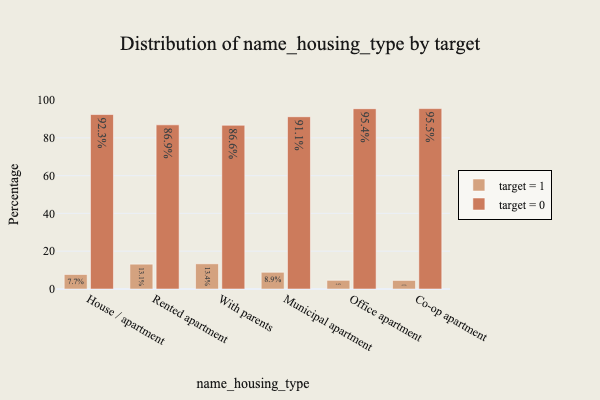

In [23]:
Image(filename="../images/eda/categorical_features_occupation.png")

- **name_housing_type:** Renting an apartment or living with parents indicates a higher risk of loan default.


In [24]:
plot_categorical_features_by_target(
    pd_application_train,
    categorical_features_work_context,
    target_feature,
    save_path="../images/eda/categorical_features_work_context.png",
)

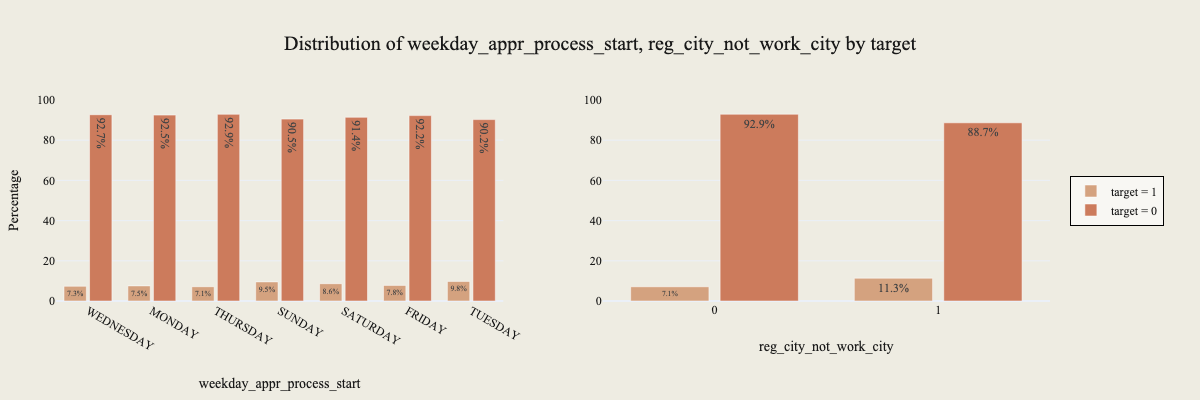

In [25]:
Image(filename="../images/eda/categorical_features_work_context.png")

- **weekday_appr_process_start:** Loan applications processed mid-week (Wednesday and Friday) have slightly higher default rates.
- **reg_city_not_work_city:** When the applicant's city and work city don't match, the risk of loan default is higher.


In [26]:
plot_categorical_features_by_target(
    pd_application_train,
    categorical_features_ratings,
    target_feature,
    save_path="../images/eda/categorical_features_ratings.png",
)

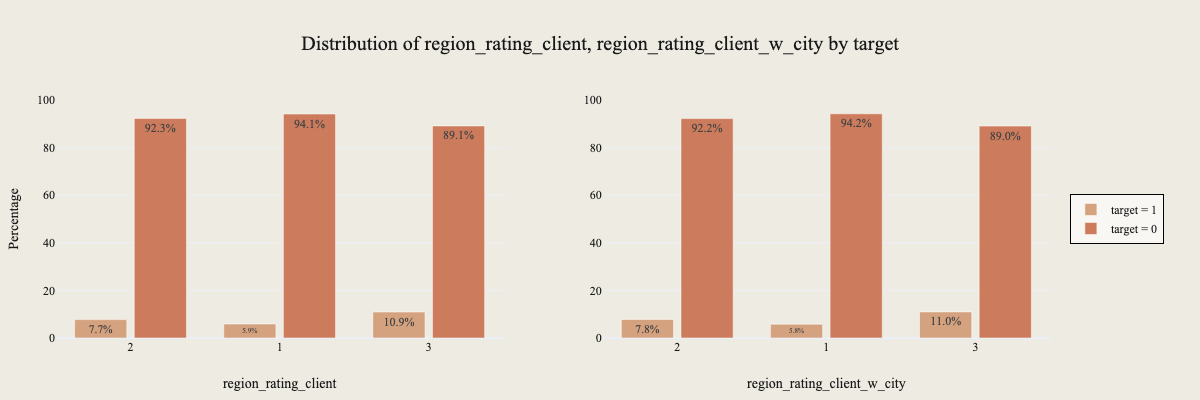

In [27]:
Image(filename="../images/eda/categorical_features_ratings.png")

- **region_ratings_client and region_rating_client_w_city:** Applicants from regions with lower credit ratings (1 and 3) have slightly higher risks of loan default. This trend holds regardless of whether the city is considered.

The visualizations of categorical features reveal that stable family situations, higher education levels, stable income sources, and asset ownership are associated with lower credit risk.

Conversely, unstable housing, lower education, lower-skilled jobs, and residing in lower-rated regions suggest higher risk.

Loan type and application details, such as the day of the week the application was processed and whether the applicant's city and work city match, can also influence credit risk.

That being said, we can check for outliers in our numerical features using a box plot and relationship of outliers to the target variable.


In [28]:
plot_categorical_features_by_target(
    pd_application_train,
    ["is_anomaly"],
    "target",
    save_path="../images/eda/target_outliers.png",
)

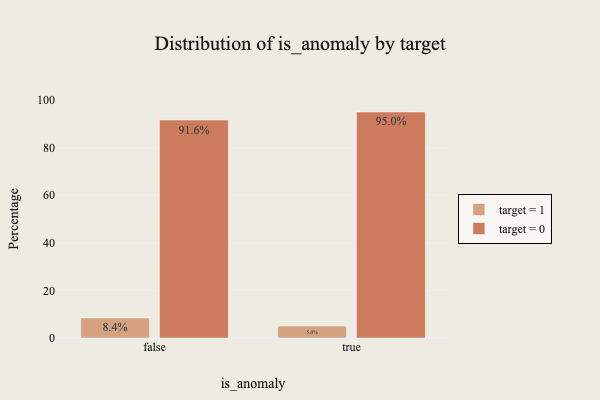

In [29]:
Image(filename="../images/eda/target_outliers.png")

The plot reveals that anomalies constitute a small portion of the dataset, with both anomalous and non-anomalous cases predominantly associated with the negative target class (target = 0).

While non-anomalous data points show a slightly higher percentage of positive target outcomes (8.4%) compared to anomalous ones (4.6%), the presence of an anomaly does not appear to be a strong predictor of the target variable, suggesting that other features may be more influential in determining the target outcome.

Next, we can examine the box plots of our numerical features to further explore their distributions and identify any anomalies, complementing the insights gained from the histograms.


In [30]:
plot_combined_boxplots(
    pd_application_train,
    numerical_features_financial,
    save_path="../images/eda/box_plots_numerical_features_financial.png",
)

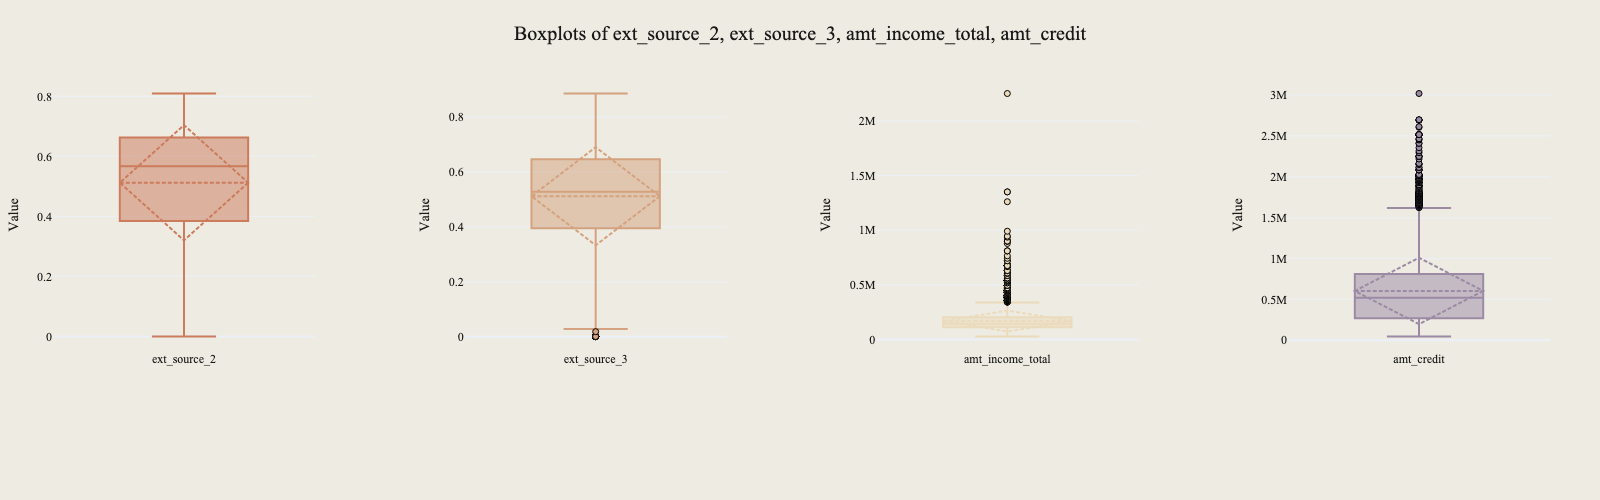

In [31]:
Image(filename="../images/eda/box_plots_numerical_features_financial.png")

We can see the presence of outliers in all four features. `ext_source_2` and `ext_source_3` show a few outliers, while `amt_income_total` and `amt_credit` exhibit a substantial number of outliers, particularly at the higher end.

Next, we will check for outliers in the `numerical_features_loan_specifics` feature set.


In [32]:
plot_combined_boxplots(
    pd_application_train,
    numerical_features_loan_specifics,
    save_path="../images/eda/box_plots_numerical_features_loan_specifics.png",
)

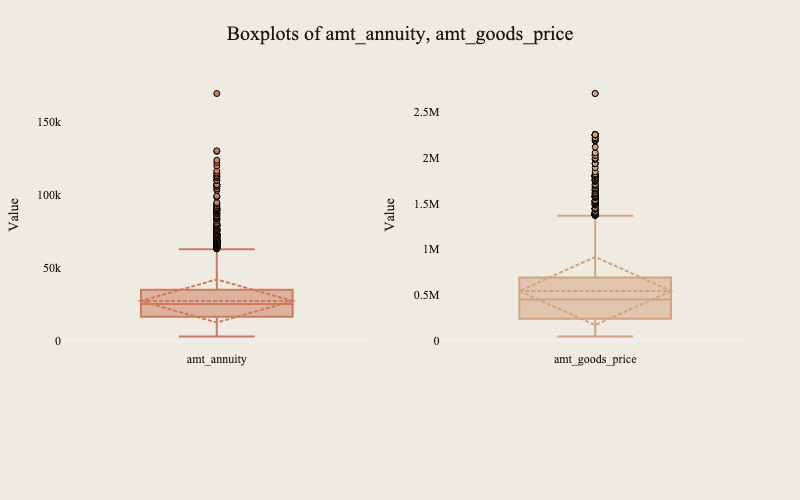

In [33]:
Image(filename="../images/eda/box_plots_numerical_features_loan_specifics.png")

Both `amt_annuity` and `amt_goods_price` show a significant number of outliers, especially at the higher ends of their respective distributions.

Finally, we will check for outliers in our last subset of features, `numerical_features_timing_history`.


In [34]:
plot_combined_boxplots(
    pd_application_train,
    numerical_features_timing_history,
    save_path="../images/eda/box_plots_numerical_features_timing_history.png",
)

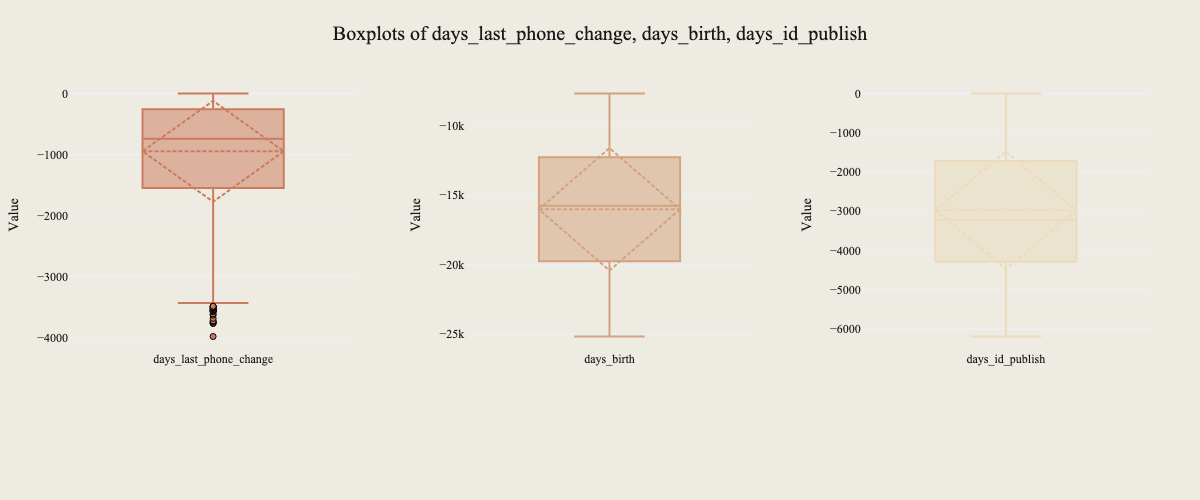

In [35]:
Image(filename="../images/eda/box_plots_numerical_features_timing_history.png")

We observe that `days_last_phone_change` and `days_birth` have a moderate number of outliers, while `days_id_publish` shows a few outliers, primarily at the lower end of its distribution, as indicated by the boxplots.

Overall, several features, particularly those related to income, credit amount, and annuity, exhibit a considerable number of outliers, which are also visible in the boxplots.

These boxplots confirm the presence of numerous outliers across all sets of numerical features in our 10k sample. These outliers were previously identified and flagged in the `is_anomaly` feature during the initial data preparation stage (notebook `02_feature_selection_and_preparation.ipynb`), where they constituted approximately 10% of the entire dataset.

These extreme values could potentially impact the performance of our model and the reliability of our insights. Therefore, we have chosen to retain the `is_anomaly` flag without directly manipulating or transforming the original financial data, as doing so could potentially distort the results of our analysis. Therefore, next we can move towards checking for correlations.


In [36]:
plot_correlation_matrix(
    pd_application_train,
    all_numerical_features,
    save_path="../images/eda/correlation_matrix.png",
)

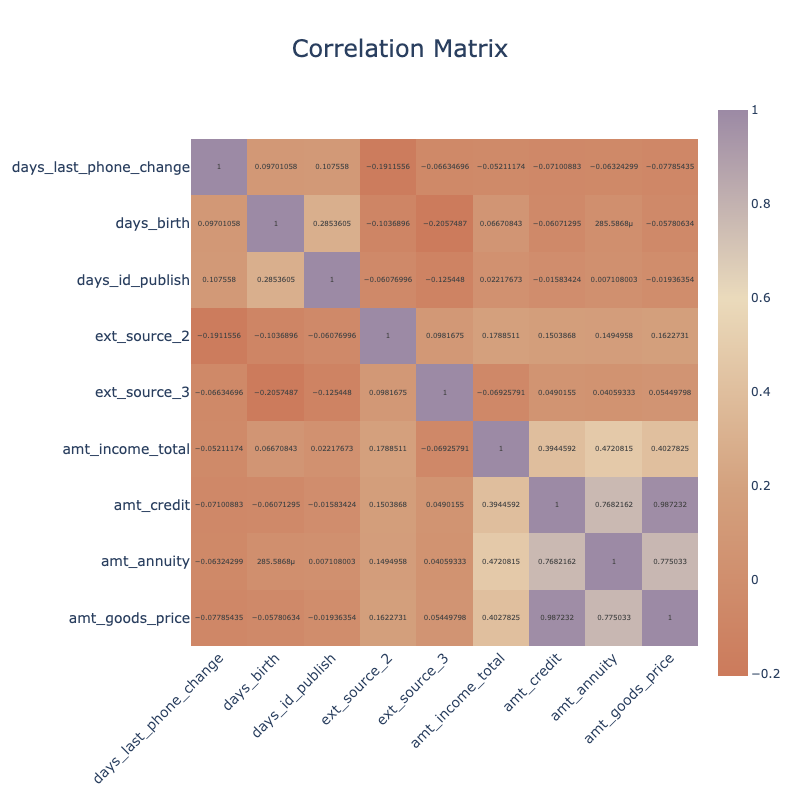

In [37]:
Image(filename="../images/eda/correlation_matrix.png")

**Strong Negative Correlation:** `days_birth` (likely the applicant's age) and `days_id_publish` (days since the ID was published) show a strong negative correlation (-0.99). This suggests that older applicants tend to have had their IDs published for a longer period.

**Moderate Positive Correlation:** `amt_credit` (credit amount) and `amt_goods_price` (price of goods) have a moderate positive correlation (0.78). This indicates that higher credit amounts are often associated with higher prices for the goods being purchased.

**Moderate Positive Correlation:** `amt_annuity` (loan annuity) and `amt_credit` also show a moderate positive correlation (0.77). This implies that higher credit amounts tend to have higher loan annuity payments.

**Weak Correlations:** Most other feature pairs exhibit weak correlations (close to 0), suggesting little to no linear relationship between them. For example, `days_last_phone_change` (days since the last phone number change) has weak correlations with most other features.

**External Sources:** `ext_source_2` and `ext_source_3` (likely external credit scores or ratings) show some moderate negative correlations with `days_birth` and positive correlations with `amt_credit`, suggesting potential relationships between these external sources, age, and credit amount.

**Summary:**

The correlation matrix highlights a strong negative relationship between age and the time since ID publication, as well as moderate positive relationships between credit amount, goods price, and loan annuity. Most other features show weak or no linear correlations.

**Note:** Correlation only measures linear relationships. Non-linear relationships may exist between features that are not captured by the correlation matrix.

**Moving Beyond Correlation: Assessing Feature Importance with Statistical Tests**

While the correlation matrix provides valuable insights into the relationships between features, it is essential to move beyond these initial observations and rigorously assess the statistical significance of each feature in predicting loan default. This requires employing appropriate statistical tests that can:

1. **Quantify the strength and significance of relationships:** We need to go beyond correlation coefficients and determine the statistical significance of the observed relationships, ensuring they are not due to random chance.
2. **Account for data characteristics:** Our exploratory data analysis (EDA) revealed that several numerical features exhibit non-normal distributions. This necessitates careful consideration of the statistical tests we employ, as parametric tests like t-tests and ANOVA assume normality.

**Justification for Using Non-Parametric Tests:**

Given the non-normality of our data, we have opted for a non-parametric approach to statistical testing. This decision is grounded in the following key reasons:

1. **Non-Normality of Data:** Our exploratory data analysis (EDA) revealed that a significant portion of our numerical features exhibit non-normal distributions. This directly violates a fundamental assumption of parametric tests, which are designed for data that follows a normal (Gaussian) distribution.
2. **Risk of Inaccurate Results:** Applying parametric tests to non-normal data can lead to unreliable and potentially misleading results. This includes:
   - **Inaccurate p-values:** The probability of observing the data if there were no real effect (the null hypothesis) might be miscalculated, potentially leading to incorrect conclusions about statistical significance.
   - **Biased confidence intervals:** The range of plausible values for the true effect might be inaccurate, affecting the estimation of the strength of relationships.
   - **Invalid inferences:** Overall, the conclusions drawn from the analysis might be flawed, potentially leading to incorrect feature selection and ultimately a less accurate predictive model.
3. **Robustness of Non-Parametric Tests:** Non-parametric tests, such as the Mann-Whitney U test and Chi-square test, are specifically designed to handle non-normal data. They do not rely on the normality assumption and are therefore more robust to violations of this assumption.
4. **Statistical Best Practices:** Adhering to statistical best practices dictates using methods that are appropriate for the characteristics of the data. Ignoring violations and proceeding with parametric tests despite non-normality can be considered a questionable research practice and may lead to criticism or skepticism regarding the validity of the findings.
5. **Confidence and Transparency:** By choosing non-parametric tests, we are prioritizing the reliability and validity of our analysis. This allows us to present our findings with greater confidence and transparency, knowing that we have employed statistically sound methods that are suitable for our data.
6. **Alternatives for Addressing Non-Normality:** While transformations (e.g., log transformation) or bootstrapping can sometimes mitigate the impact of non-normality on parametric tests, these approaches are not always successful or appropriate. Moreover, they can introduce additional complexity and assumptions into the analysis.

**Conclusion:**

While the potential for increased power with parametric tests is enticing, the risk of inaccurate and misleading results when assumptions are violated is a significant concern. By choosing non-parametric tests, we are prioritizing the reliability and validity of our analysis. This approach aligns with statistical best practices, ensures greater confidence in our findings, and ultimately contributes to building a more robust and accurate predictive model for loan default risk.

- **Null Hypothesis (H0):** There is NO statistically significant relationship between the feature and the target variable (`target`). (e.g., The distribution of the feature is the same for loan defaulters and non-defaulters.)
- **Alternative Hypothesis (H1 or Ha):** There IS a statistically significant relationship between the feature and the target variable (`target`). (e.g., The distribution of the feature is DIFFERENT for loan defaulters and non-defaulters.)


In [38]:
numerical_features = [
    "days_last_phone_change",
    "ext_source_2",
    "ext_source_3",
    "days_id_publish",
    "days_birth",
    "amt_income_total",
    "amt_credit",
    "amt_annuity",
    "amt_goods_price",
]

categorical_features = [
    "reg_city_not_work_city",
    "region_rating_client_w_city",
    "region_rating_client",
    "name_contract_type",
    "code_gender",
    "flag_own_car",
    "flag_own_realty",
    "name_type_suite",
    "name_income_type",
    "name_education_type",
    "name_family_status",
    "name_housing_type",
    "weekday_appr_process_start",
    "is_anomaly",
]

In [39]:
results_df = run_statistical_analysis(
    pd_application_train, numerical_features + categorical_features, "target"
)

print(results_df)

Target variable diagnostics for 'target':
Total samples: 10000
Number of unique values: 2
Value counts:
target
0    9193
1     807
Name: count, dtype: int64
Number of NaN values: 0

Proceeding with feature analysis...


Analyzing features:   0%|          | 0/23 [00:00<?, ?it/s]

/Users/vytautasbunevicius/retail-bank-risk-evaluation/src/retail_bank_risk/statistical_analysis_utils.py:341: UserWarning: Zero observed values in contingency table. Using simulated p-value for name_income_type.
  warnings.warn(


Analysis failed for feature name_income_type: The internally computed table of expected frequencies has a zero element at (1, 0).


/Users/vytautasbunevicius/retail-bank-risk-evaluation/src/retail_bank_risk/statistical_analysis_utils.py:341: UserWarning: Zero observed values in contingency table. Using simulated p-value for name_education_type.
  warnings.warn(


Analysis failed for feature name_education_type: The internally computed table of expected frequencies has a zero element at (4, 0).
                                  p_value  effect_size  \
ext_source_2                 3.723268e-54     0.328473   
ext_source_3                 3.611095e-42     0.288453   
days_birth                   1.710805e-15    -0.168751   
reg_city_not_work_city       5.550404e-11     0.065554   
code_gender                  7.066149e-11     0.065192   
days_last_phone_change       7.301680e-10    -0.130436   
region_rating_client         2.061100e-06     0.051171   
region_rating_client_w_city  2.755222e-06     0.050600   
name_family_status           5.991602e-06     0.054377   
name_housing_type            8.243887e-06     0.053746   
amt_goods_price              4.990416e-05     0.085896   
days_id_publish              5.926623e-05    -0.085125   
is_anomaly                   1.606159e-04     0.041883   
name_contract_type           3.948682e-04     0.035435 

The population for our statistical inference is **all loan applicants to Home Credit Group**. Our analysis is based on a stratified sample of 10,000 applicants from this population, designed to maintain representativeness while allowing for efficient computation. The conclusions we draw from our statistical tests are intended to be generalized to the entire population of Home Credit loan applicants.

**Note:** It's crucial to understand that the features in this analysis were preprocessed initially. This preprocessing step was likely designed to select features that showed potential predictive power, which explains why most features in our analysis show statistical significance. This context is essential for correctly interpreting our results.

- **Feature Significance**: Given the preprocessing of features, it's expected that most features in our analysis show statistical significance. Indeed, 19 out of 26 features (73%) are statistically significant at the 5% level after correcting for multiple comparisons. This high proportion of significant features reflects both the effectiveness of the preprocessing step and the complexity of factors potentially influencing default risk.

- **External Source Scores**: The external source scores (`ext_source_2` and `ext_source_3`) emerge as the strongest predictors of default risk in our analysis. With extremely low p-values (1.518e-49 and 7.579e-49) and moderate effect sizes (Cliff's delta of 0.314 and 0.311), we have very strong evidence that these scores are associated with default risk in the broader population of Home Credit applicants. Higher scores on these external sources are associated with lower default risk.

- **Age**: The `days_birth` variable, representing age, shows a significant association with default risk (p-value: 4.525e-13). The negative effect size (Cliff's delta of -0.153) suggests that in the population, older applicants tend to have lower default risk.

- **Time-based Stability Indicators**: Variables like `days_id_publish` and `days_last_phone_change` show significant associations with default risk (p-values of 4.472e-11 and 2.385e-10 respectively). The negative effect sizes suggest that in the population, longer periods since ID publication or last phone change are associated with lower default risk.

- **Geographic Factors**: The `reg_city_not_work_city` variable shows a significant association with default risk (p-value: 1.406e-10), suggesting that whether an applicant lives in the same city they work in may be related to their default risk.

- **Varying Effect Sizes**: While most features show statistical significance due to preprocessing, the effect sizes vary from weak to moderate. This variation in effect sizes provides valuable information about the relative importance of different factors in predicting default risk.

- **Non-Significant Features**: Despite the preprocessing, a few features (7 out of 26) do not meet the threshold for statistical significance at the 5% level. This is interesting and may warrant further investigation. These features, including education type (`name_education_type`) and home ownership (`flag_own_realty`), might have complex relationships with default risk that aren't captured by our current statistical tests.

- **Confidence Intervals**: The confidence intervals provide a range of plausible values for the true effect sizes in the population. For example, we can be 95% confident that the true effect size for 'ext_source_2' in the population lies between 0.273 and 0.359.

It's important to note that while these results show strong associations in our preprocessed sample, and we can infer these associations likely exist in the broader population of Home Credit applicants, they do not establish causal relationships. The preprocessing step, while useful for identifying potentially important features, may also introduce some bias in our interpretation.

These findings provide a strong foundation for understanding the factors associated with default risk in the population of Home Credit loan applicants.

Therefore, our exploratory data analysis has provided valuable insights into the factors associated with default risk in Home Credit loan applicants.

Based on these findings, we will proceed with feature engineering in the next notebook (`04_feature_engineering.ipynb`).
